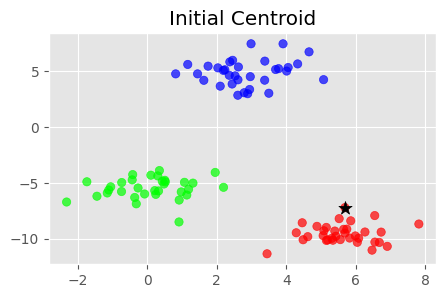

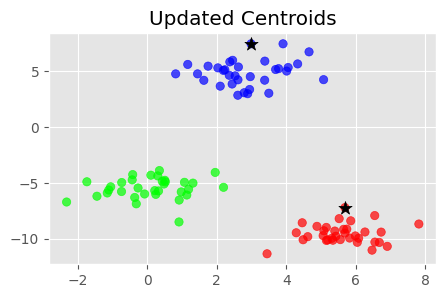

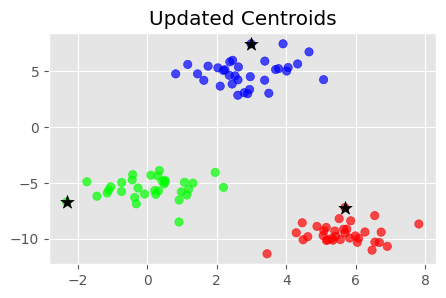

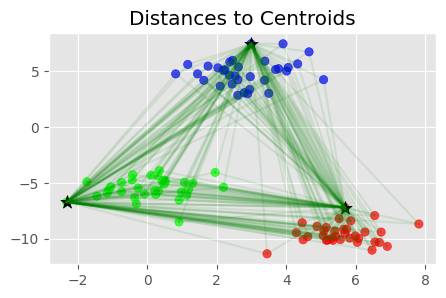

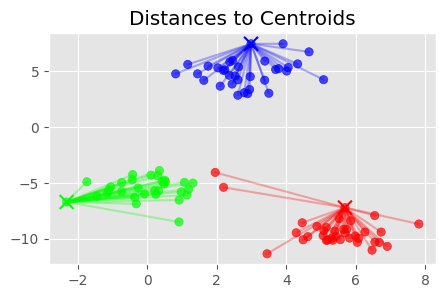

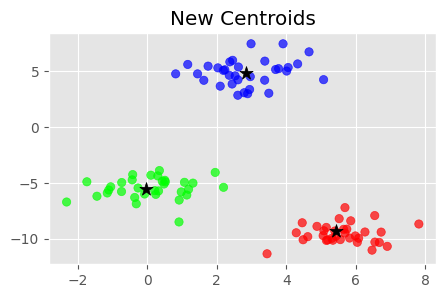

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from matplotlib.colors import ListedColormap

plt.style.use('ggplot')

# Define colors for 3 clusters
colors = ("#FF0000", '#0000FF', '#00FF00')
cm_bright = ListedColormap(colors)

# Generate sample data with 3 clusters
X, y = make_blobs(n_samples=100, random_state=10, centers=3)

# Function to plot data and centroids
def plot_data(X, centroids, title="Data and Centroids"):
    plt.figure(figsize=(5, 3))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright, alpha=0.7)
    plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=100, marker='*')
    plt.title(title)
    plt.show()

# Function to plot distances from each point to its assigned centroid
def plot_distances(X, centroids, clusters):
    plt.figure(figsize=(5, 3))
    for i, x in enumerate(X):
        centroid_idx = clusters[i]
        centroid = centroids[centroid_idx]
        plt.plot([x[0], centroid[0]], [x[1], centroid[1]], color=colors[centroid_idx], alpha=0.3)

    plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap=cm_bright, alpha=0.7)
    plt.scatter(centroids[:, 0], centroids[:, 1], c=colors, s=100, marker='x')
    plt.title("Distances to Centroids")
    plt.show()

# Function to plot distances from each point to each centroid
def plot_all_distances(X, centroids):
    plt.figure(figsize=(5, 3))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright, alpha=0.7)
    for centroid in centroids:
        for point in X:
            plt.plot([point[0], centroid[0]], [point[1], centroid[1]], 'g-', alpha=0.1)
    plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=100, marker='*')
    plt.title("Distances to Centroids")
    plt.show()

# Function to assign points to the nearest centroid
def assign_clusters(X, centroids):
    clusters = []
    for x in X:
        distances = np.linalg.norm(centroids - x, axis=1)
        cluster = np.argmin(distances)
        clusters.append(cluster)
    return np.array(clusters)

# Function to compute new centroids
def compute_new_centroids(X, clusters, k):
    new_centroids = []
    for i in range(k):
        cluster_points = X[clusters == i]
        new_centroid = cluster_points.mean(axis=0)
        new_centroids.append(new_centroid)
    return np.array(new_centroids)

# k-means++ initialization
def kmeanspp(X, k=3, seed=0):
    centroids = []
    np.random.seed(seed)
    centroid_id = np.random.choice(X.shape[0])
    centroids.append(X[centroid_id])
    plot_data(X, np.array(centroids), "Initial Centroid")

    for _ in range(k-1):
        dists = []
        for x in X:
            distances = np.linalg.norm(centroids - x, axis=1)
            dists.append(distances.min())
        obj_ind = np.array(dists).argmax()
        next_centroid = X[obj_ind]
        centroids.append(next_centroid)
        plot_data(X, np.array(centroids), "Updated Centroids")

    centroids = np.array(centroids)
    return centroids

# Generate initial centroids using k-means++
centroids = kmeanspp(X, k=3, seed=10)

# Plot all distances from points to centroids
plot_all_distances(X, centroids)

# Assign points to nearest centroids
clusters = assign_clusters(X, centroids)

# Plot distances from each point to its assigned centroid
plot_distances(X, centroids, clusters)

# Compute new centroids
new_centroids = compute_new_centroids(X, clusters, k=3)

# Plot new centroids
plot_data(X, new_centroids, "New Centroids")


In [3]:
def plot_cluster(X,centroids, cluster_label, centroids_label, old_centroids = None, old_centroids_label = None):
    """Cluster visualization
    Input variables:
    ===========
    X: attributes
    centroids: current cluster centers
    cluster_label: cluster labels for features
    centroids_label: labels for current cluster centers
    old_centroids: previous cluster centers
    old_centroids_label: labels for previous cluster centers
    """
    fig = plt.figure(figsize=(10,5)) # Create a canvas
    # Visualize our features
    plt.scatter(X[:, 0], X[:, 1],
                c = cluster_label, cmap = 'bwr',
                s=100,alpha = 0.6)
    # Visualize the current cluster centers. Like points, but bigger
    plt.scatter(centroids[:, 0], centroids[:, 1],
                c = centroids_label, cmap = 'bwr',
                s=400, edgecolors = 'k')

    if old_centroids is not None: # if we want to visualize the previous centers of clusters
        # they will be smaller than the current centers, but larger than the “row points”.
        plt.scatter(old_centroids[:, 0], old_centroids[:, 1],
            c = old_centroids_label, cmap = 'bwr',
            s=200, edgecolors = 'k')

    plt.xticks([])
    plt.yticks([])

In [2]:
class KMeans():
    def __init__(self,n_clusters = 2, centroids = None,
                 max_iter=10, tol=0.01,
                 metric = 'euclidean', p = 2,
                 random_state = None):
        self.n_clusters = n_clusters
        self.centroids  = centroids
        self.max_iter   = max_iter
        self.tol        = tol
        self.iters      = None
        self.inertia = None
        self.metric = metric
        self.p  = p
        self.random_state  = random_state
    #-------------------------------------
    def distance(self,X1, X2):
        # distance
        if self.metric == 'euclidean':
            dist = np.sqrt(np.sum(np.square(X1 - X2).T,axis=0))
        if self.metric == 'cityblock':
            dist = np.sum(np.abs(X1 - X2).T,axis=0)
        if self.metric == 'Chebyshev':
            dist = np.max(np.abs(X1 - X2).T,axis=0)
        if self.metric == 'Minkowski':
            dist = np.power(np.sum(np.power(np.abs(X1 - X2),self.p).T,axis=0),1/self.p)
        return dist
    #-------------------------------------
    def init_centroids(self, X):
        # Initialization of the first cluster centers
        if self.random_state: rng = np.random.seed(self.random_state)
        c_idxs = np.random.randint(0, X.shape[0], size = self.n_clusters)
        return X[c_idxs,:]
    #-------------------------------------
    def predict(self, X):
        # distance-based estimation of points belonging to a cluster
        distances = np.zeros((X.shape[0], self.n_clusters))

        for i,centr in enumerate(self.centroids):
            distances[:,i] = self.distance(centr,X)
        self.inertia = np.sum(np.power(np.min(distances,axis = 1),2))
        return np.argmin(distances,axis = 1)
    #-------------------------------------
    def transform(self,X):
        # prediction
        return self.predict(X)
    #-------------------------------------
    def delta_centroids(self,old_centroids):
        # value of relative change in the centers of clusters
        return (
                self.distance(self.centroids,old_centroids)/
                self.distance(old_centroids, np.mean(old_centroids))
               ).mean()
    #-------------------------------------
    def fit(self, X):
        # training - several iterations of the k-means algorithm
        if self.centroids is None:
            self.centroids = self.init_centroids(X)

        d_centrs = np.inf

        for i in range(self.max_iter):

            old_centroids = np.copy(self.centroids)

            cluster_label = self.predict(X)

            for k in range(self.n_clusters):

                c_idxs = np.flatnonzero(cluster_label==k)

                self.centroids[k] = X[c_idxs].mean(axis = 0)

            d_centrs = self.delta_centroids(old_centroids)

            self.iters = i
            if d_centrs<=self.tol:
                break
        return self
    #-------------------------------------
    def fit_transform(self, X):
        # and train and give out cluster labels immediately
        return self.fit(X).predict(X)



We have stopped at iteration:: 2


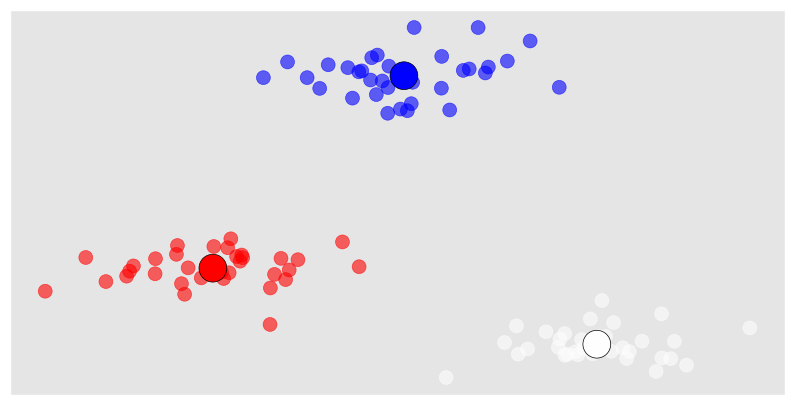

In [4]:
kmeans = KMeans(n_clusters=3,max_iter=100, tol=0.01, random_state= 42) # create object
c_labels = kmeans.fit_transform(X) # train and immediately stack cluster labels

print('We have stopped at iteration::',kmeans.iters)

# visualize
plot_cluster(X,kmeans.centroids,
             c_labels, np.unique(c_labels),)